# Customer Personality Analysis

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AffinityPropagation

## Preprocessing

In [ ]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single  58138.0        0   
1      2174        1954  Graduation         Single  46344.0        1   
2      4141        1965  Graduation       Together  71613.0        0   
3      6182        1984  Graduation       Together  26646.0        1   
4      5324        1981         PhD        Married  58293.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married  61223.0        0   
2236   4001        1946         PhD       Together  64014.0        2   
2237   7270        1981  Graduation       Divorced  56981.0        0   
2238   8235        1956      Master       Together  69245.0        0   
2239   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  \
0            0  04-09-2012       58       635  ...                  7   
1            1  08-03-2014       38        11  ...                  5   
2            0  21-08-2013       26       426  ...                  4   
3            0  10-02-2014       26        11  ...                  6   
4            0  19-01-2014       94       173  ...                  5   
...        ...         ...      ...       ...  ...                ...   
2235         1  13-06-2013       46       709  ...                  5   
2236         1  10-06-2014       56       406  ...                  7   
2237         0  25-01-2014       91       908  ...                  6   
2238         1  24-01-2014        8       428  ...                  3   
2239         1  15-10-2012       40        84  ...                  7   

      AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
2235             0             0             0             0             0   
2236             0             0             0             1             0   
2237             0             1             0             0             0   
2238             0             0             0             0             0   
2239             0             0             0             0             0   

      Complain  Z_CostContact  Z_Revenue  Response  
0            0              3         11         1  
1            0              3         11         0  
2            0              3         11         0  
3            0              3         11         0  
4            0              3         11         0  
...        ...            ...        ...       ...  
2235         0              3         11         0  
2236         0              3         11         0  
2237         0              3         11         0  
2238         0              3         11         0  
2239         0              3         11         1  

[2240 rows x 29 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [ ]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

max(df['Dt_Customer'])

Timestamp('2014-06-29 00:00:00')

In [ ]:
reference_date = pd.to_datetime('2015-01-01')
df['days_customer'] = (reference_date - df['Dt_Customer']).dt.days
df['Age'] = reference_date.year - df['Year_Birth']

# 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response'
df = df.drop(['ID', 'Year_Birth', 'Dt_Customer', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Z_CostContact', 'Z_Revenue'], axis=1)

In [ ]:
print(df['Education'].value_counts())
print()
print(df['Marital_Status'].value_counts())

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


In [ ]:
df = df[~df['Marital_Status'].isin(['YOLO', 'Absurd', 'Alone'])]

In [ ]:
education_mapping = {
    'Basic': 0,
    '2n Cycle': 1,
    'Graduation': 2,
    'Master': 3,
    'PhD': 4
}

marital_mapping = {
    'Single': 0,
    'Together': 1,
    'Married': 2,
    'Divorced': 3,
    'Widow': 4
}

df['Education'] = df['Education'].map(education_mapping)
df['Marital_Status'] = df['Marital_Status'].map(marital_mapping)

In [ ]:
df.describe()

Education  Marital_Status         Income      Kidhome     Teenhome  \
count  2233.000000     2233.000000    2209.000000  2233.000000  2233.000000   
mean      2.458128        1.483206   52243.977818     0.444245     0.506046   
std       1.004099        1.046333   25198.475858     0.538528     0.544675   
min       0.000000        0.000000    1730.000000     0.000000     0.000000   
25%       2.000000        1.000000   35246.000000     0.000000     0.000000   
50%       2.000000        2.000000   51390.000000     0.000000     0.000000   
75%       3.000000        2.000000   68627.000000     1.000000     1.000000   
max       4.000000        4.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2233.000000  2233.000000  2233.000000      2233.000000   
mean     49.172414   304.033587    26.300940       167.113300   
std      28.962114   336.953019    39.779532       225.870588   
min       0.000000     0.000000     0.000000         0.000000   
25%      24.000000    24.000000     1.000000        16.000000   
50%      50.000000   173.000000     8.000000        67.000000   
75%      74.000000   505.000000    33.000000       232.000000   
max      99.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count      2233.000000       2233.000000   2233.000000        2233.000000   
mean         37.445141         27.108374     43.903269           2.321093   
std          54.461569         41.321700     52.009602           1.932181   
min           0.000000          0.000000      0.000000           0.000000   
25%           3.000000          1.000000      9.000000           1.000000   
50%          12.000000          8.000000     24.000000           2.000000   
75%          50.000000         33.000000     56.000000           3.000000   
max         259.000000        263.000000    362.000000          15.000000   

       NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
count      2233.000000          2233.000000         2233.00000   
mean          4.081505             2.661890            5.79176   
std           2.776886             2.921749            3.25473   
min           0.000000             0.000000            0.00000   
25%           2.000000             0.000000            3.00000   
50%           4.000000             2.000000            5.00000   
75%           6.000000             4.000000            8.00000   
max          27.000000            28.000000           13.00000   

       NumWebVisitsMonth     Complain  days_customer          Age  
count        2233.000000  2233.000000    2233.000000  2233.000000  
mean            5.316167     0.009404     539.557546    46.209136  
std             2.425668     0.096541     201.971642    11.979248  
min             0.000000     0.000000     186.000000    19.000000  
25%             3.000000     0.000000     367.000000    38.000000  
50%             6.000000     0.000000     541.000000    45.000000  
75%             7.000000     0.000000     714.000000    56.000000  
max            20.000000     1.000000     885.000000   122.000000

In [ ]:
def remove_outliers(df, cols):
    df_no_outliers = df.copy()
    for col in cols:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

    return df_no_outliers.reset_index(drop=True)

cols = ['Income', 'Age']
df = remove_outliers(df, cols)

In [ ]:
df

Education  Marital_Status   Income  Kidhome  Teenhome  Recency  \
0             2               0  58138.0        0         0       58   
1             2               0  46344.0        1         1       38   
2             2               1  71613.0        0         0       26   
3             2               1  26646.0        1         0       26   
4             4               2  58293.0        1         0       94   
...         ...             ...      ...      ...       ...      ...   
2193          2               2  61223.0        0         1       46   
2194          4               1  64014.0        2         1       56   
2195          2               3  56981.0        0         0       91   
2196          3               1  69245.0        0         1        8   
2197          4               2  52869.0        1         1       40   

      MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0          635         88              546              172                88   
1           11          1                6                2                 1   
2          426         49              127              111                21   
3           11          4               20               10                 3   
4          173         43              118               46                27   
...        ...        ...              ...              ...               ...   
2193       709         43              182               42               118   
2194       406          0               30                0                 0   
2195       908         48              217               32                12   
2196       428         30              214               80                30   
2197        84          3               61                2                 1   

      MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
0               88                  3                8                   10   
1                6                  2                1                    1   
2               42                  1                8                    2   
3                5                  2                2                    0   
4               15                  5                5                    3   
...            ...                ...              ...                  ...   
2193           247                  2                9                    3   
2194             8                  7                8                    2   
2195            24                  1                2                    3   
2196            61                  2                6                    5   
2197            21                  3                3                    1   

      NumStorePurchases  NumWebVisitsMonth  Complain  days_customer  Age  
0                     4                  7         0            849   58  
1                     2                  5         0            299   61  
2                    10                  4         0            498   50  
3                     4                  6         0            325   31  
4                     6                  5         0            347   34  
...                 ...                ...       ...            ...  ...  
2193                  4                  5         0            567   48  
2194                  5                  7         0            205   69  
2195                 13                  6         0            341   34  
2196                 10                  3         0            342   59  
2197                  4                  7         0            808   61  

[2198 rows x 20 columns]

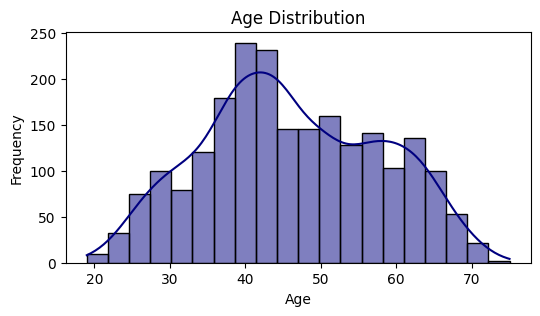

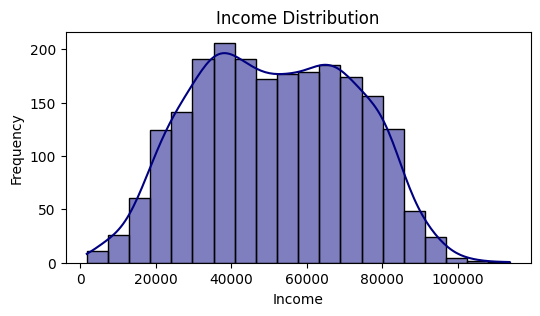

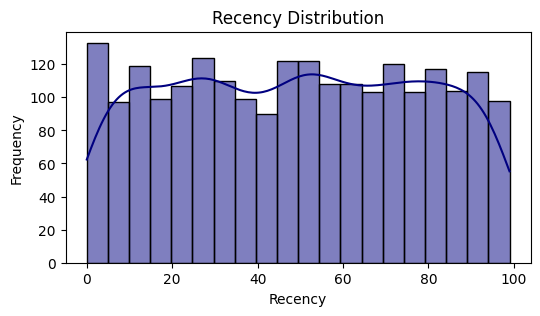

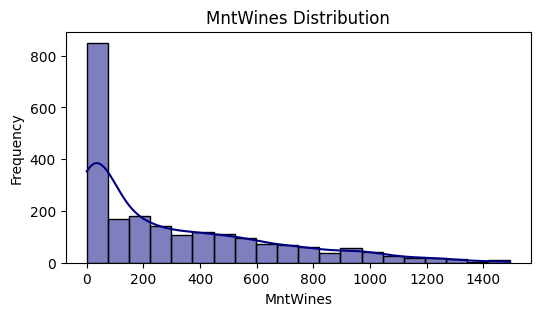

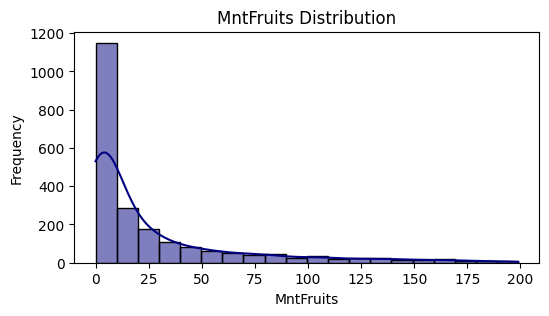

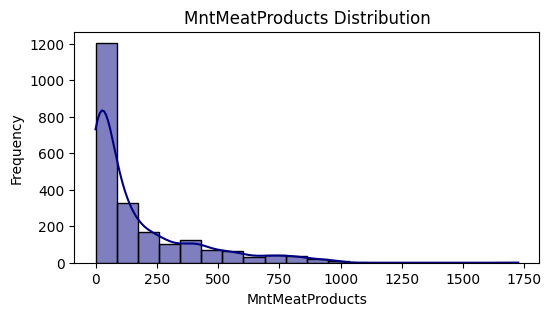

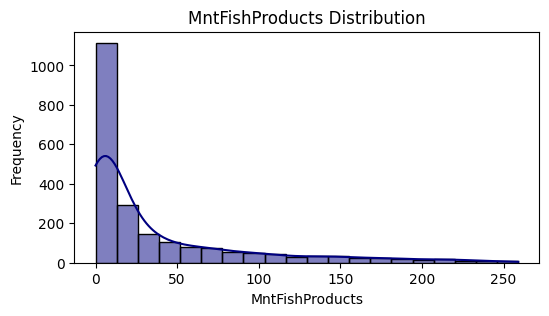

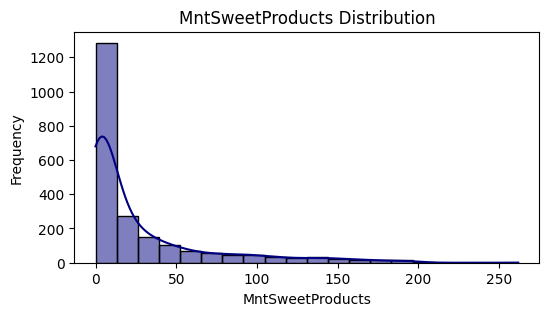

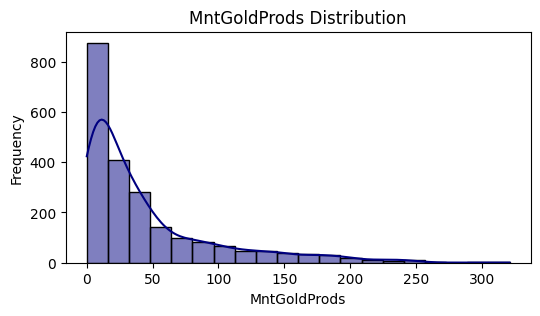

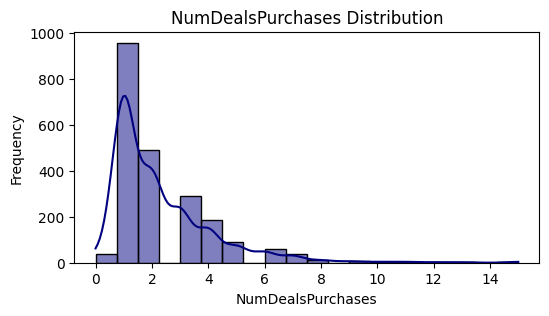

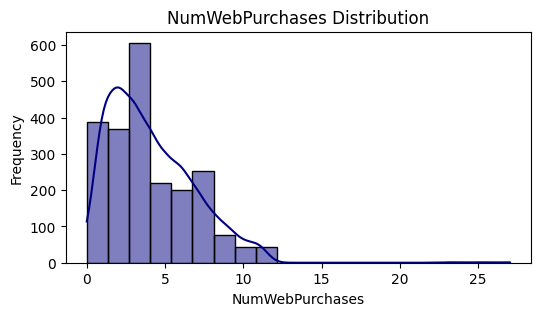

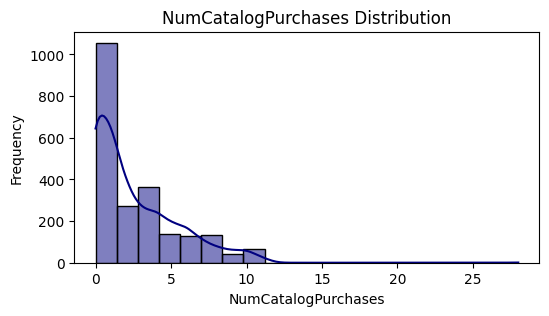

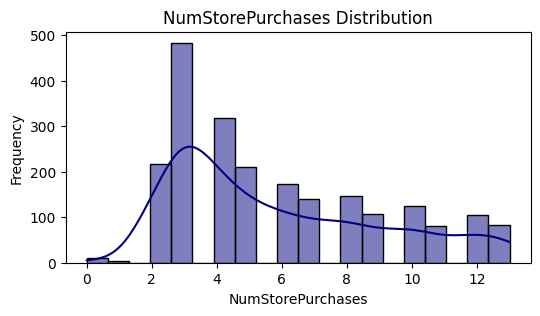

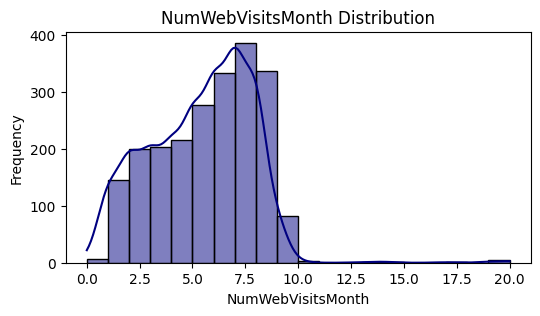

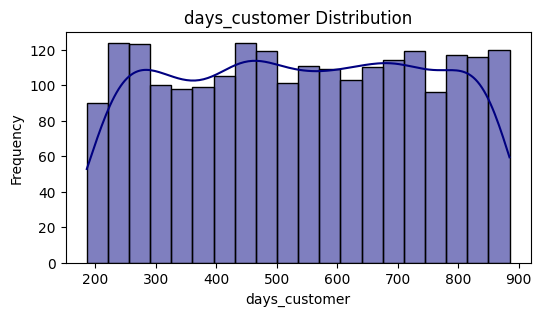

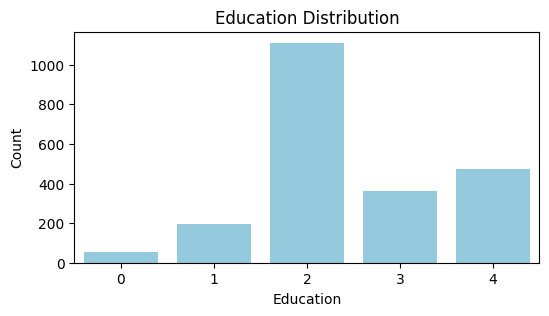

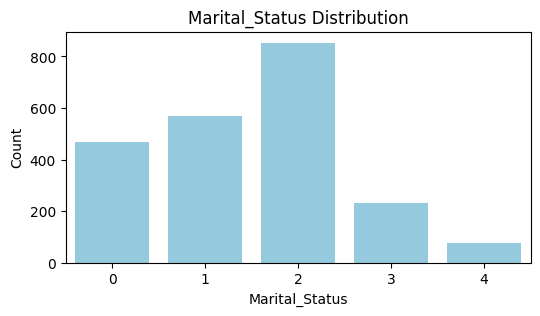

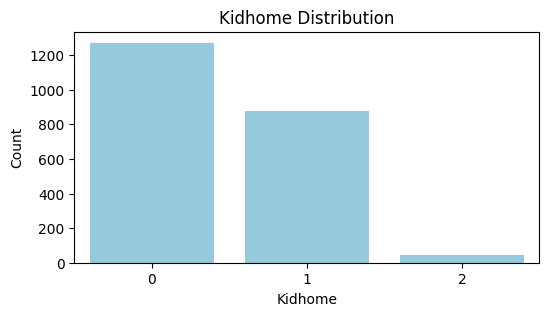

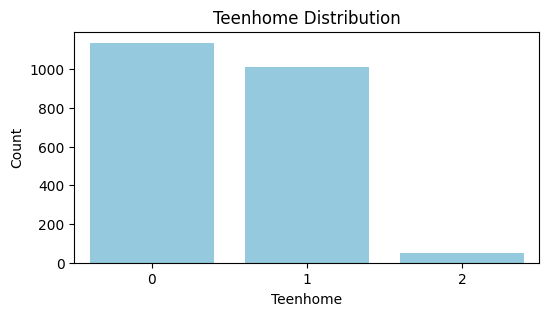

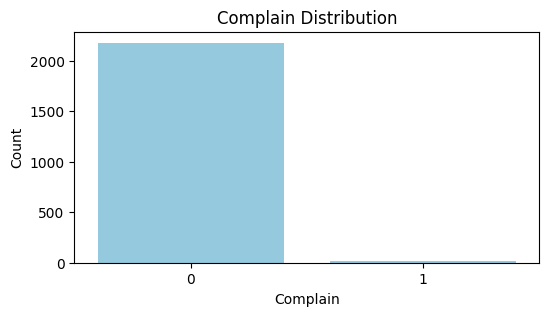

In [ ]:
def plot_hist(feature):
    plt.figure(figsize=(6, 3))
    sns.histplot(df[feature], bins=20, kde=True, color='navy')
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

def plot_barplot(feature):
    plt.figure(figsize=(6, 3))
    sns.countplot(x=df[feature], color='skyblue')
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

numerical_features = ['Age', 'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'days_customer']
categorical_features = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Complain']

for feature in numerical_features:
    plot_hist(feature)

for feature in categorical_features:
    plot_barplot(feature)

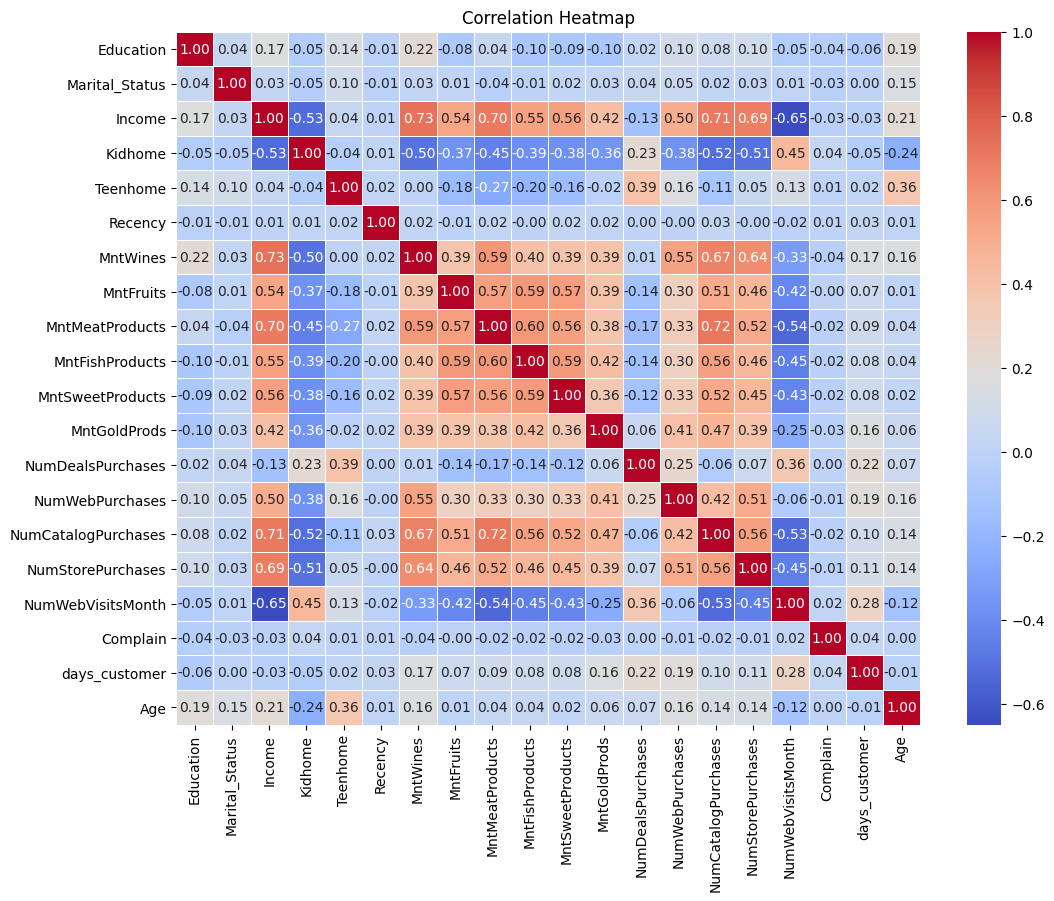

In [ ]:
corr = df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Dimentionality Reduction: PCA

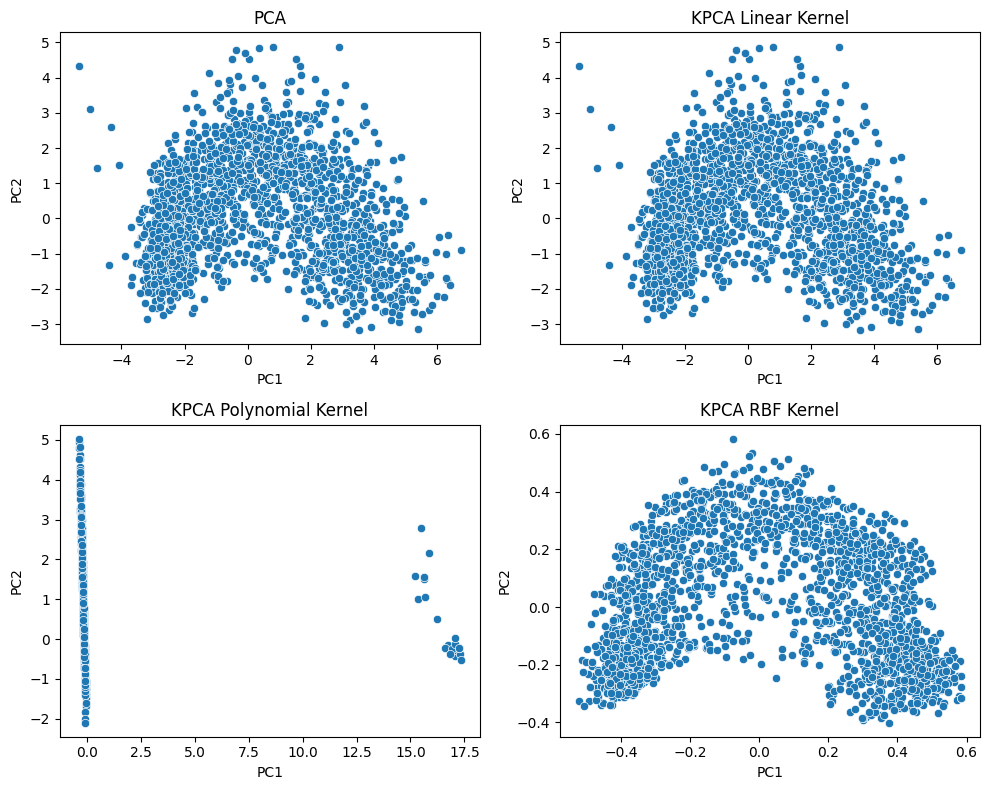

In [ ]:
df = df.dropna()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

pca = PCA(n_components=7)
X_pca = pca.fit_transform(df_scaled)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kpca_results = []
kpcas = []

for kernel in kernels:
    kpca = KernelPCA(kernel=kernel, n_components=2)
    X_kpca = kpca.fit_transform(df_scaled)
    kpcas.append(kpca)
    kpca_results.append(X_kpca)

fig, axes = plt.subplots(2, 2, figsize=(10,8))

# PCA
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], ax=axes[0, 0])
axes[0, 0].set_title('PCA')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

# KPCA with linear kernel
sns.scatterplot(x=kpca_results[0][:, 0], y=kpca_results[0][:, 1], ax=axes[0, 1])
axes[0, 1].set_title('KPCA Linear Kernel')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')

# KPCA with polynomial kernel
sns.scatterplot(x=kpca_results[1][:, 0], y=kpca_results[1][:, 1], ax=axes[1, 0])
axes[1, 0].set_title('KPCA Polynomial Kernel')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')

# KPCA with RBF kernel
sns.scatterplot(x=kpca_results[2][:, 0], y=kpca_results[2][:, 1], ax=axes[1, 1])
axes[1, 1].set_title('KPCA RBF Kernel')
axes[1, 1].set_xlabel('PC1')
axes[1, 1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

PCA Loadings:
                          PC1       PC2       PC3       PC4       PC5  \
Education            0.028254  0.219050 -0.399805 -0.524552 -0.051143   
Marital_Status       0.012440  0.150275 -0.124890  0.571479 -0.249908   
Income               0.347665  0.052207 -0.165003 -0.074504  0.024442   
Kidhome             -0.264356 -0.044954  0.159005 -0.094412 -0.001405   
Teenhome            -0.041310  0.492369 -0.189169  0.223153  0.104040   
Recency              0.006199  0.007864  0.028394  0.001271  0.634474   
MntWines             0.302305  0.183840 -0.017273 -0.276819 -0.022172   
MntFruits            0.276330 -0.142909  0.137093  0.156597 -0.016188   
MntMeatProducts      0.320900 -0.133600  0.036364 -0.132014  0.017825   
MntFishProducts      0.286160 -0.154429  0.141875  0.160600 -0.014959   
MntSweetProducts     0.277504 -0.127478  0.136620  0.163334 -0.004000   
MntGoldProds         0.228165  0.082362  0.238192  0.173727 -0.042782   
NumDealsPurchases   -0.053248  0.4665

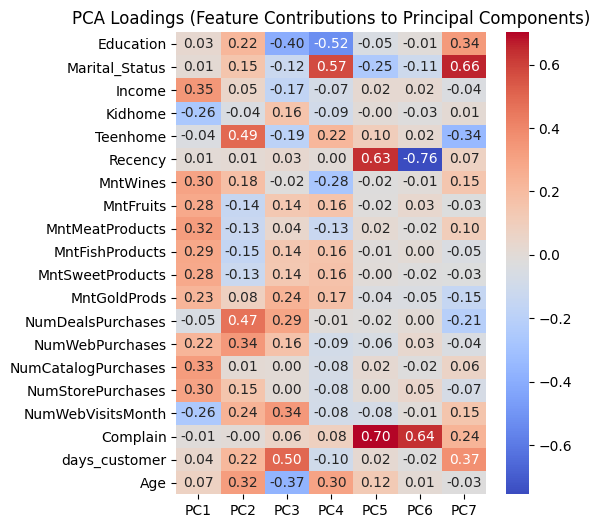

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=df.columns
)

print("PCA Loadings:")
print(loadings)

plt.figure(figsize=(5, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("PCA Loadings (Feature Contributions to Principal Components)")
plt.show()

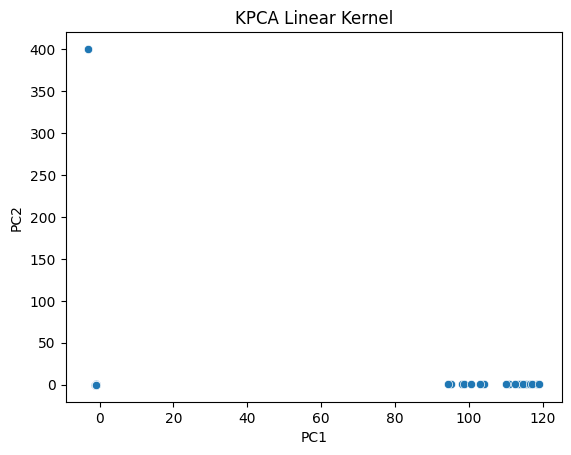

In [ ]:
kpca = KernelPCA(kernel='poly', degree=5, n_components=7)
X_kpca = kpca.fit_transform(df_scaled)

sns.scatterplot(x=X_kpca[:, 0], y=X_kpca[:, 1])
plt.title('KPCA Linear Kernel')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

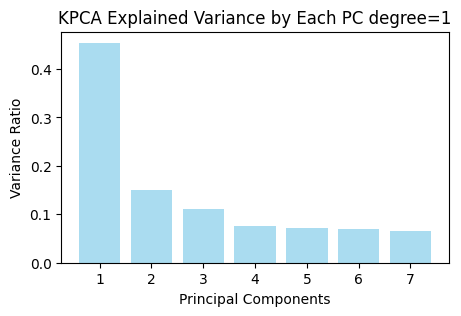

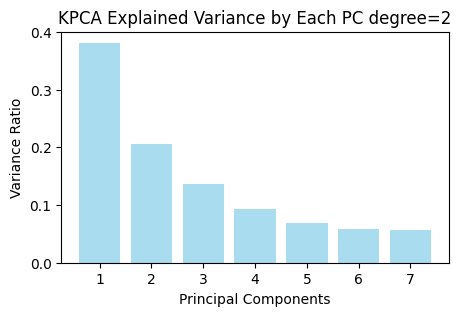

In [ ]:
for degree in range(1,3):
    kpca = KernelPCA(kernel='poly', degree=degree, n_components=7)
    X_kpca = kpca.fit_transform(df_scaled)

    eigenvalues = kpca.eigenvalues_
    explained_variance = eigenvalues / eigenvalues.sum()

    plt.figure(figsize=(5, 3))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Ratio')
    plt.title(f'KPCA Explained Variance by Each PC degree={degree}')
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.show()

## Dimentionality Reduction: t-SNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_scaled)

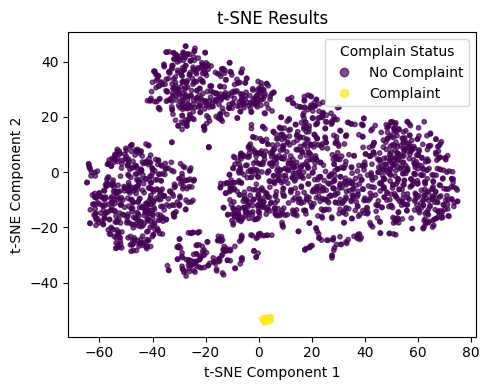

In [ ]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, s=10, c=df['Complain'], cmap='viridis')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = ['No Complaint', 'Complaint']
plt.legend(handles, legend_labels, title="Complain Status")

plt.title('t-SNE Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

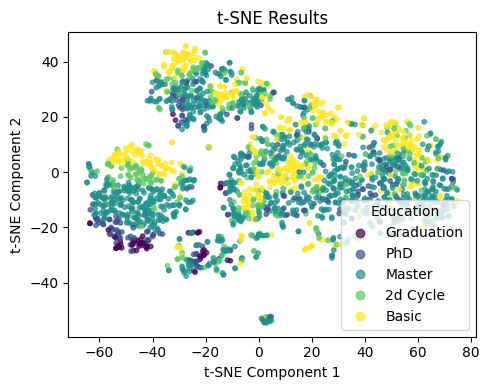

In [ ]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, s=10, c=df['Education'], cmap='viridis')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = ['Graduation', 'PhD', 'Master', '2d Cycle', 'Basic']
plt.legend(handles, legend_labels, title="Education")

plt.title('t-SNE Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

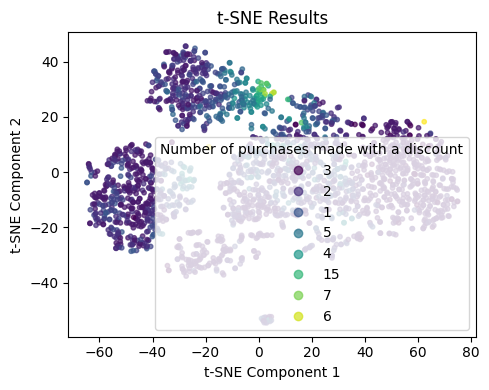

In [ ]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, s=10, c=df['NumDealsPurchases'], cmap='viridis')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = df['NumDealsPurchases'].unique()
plt.legend(handles, legend_labels, title="Number of purchases made with a discount")

plt.title('t-SNE Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

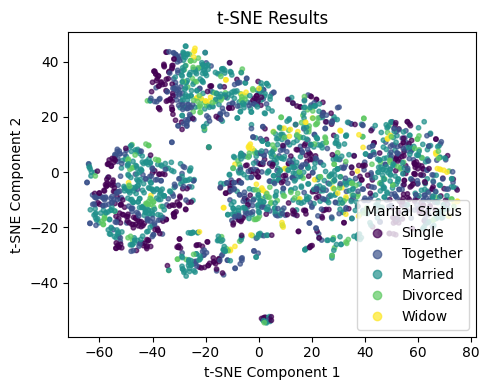

In [ ]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, s=10, c=df['Marital_Status'], cmap='viridis')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = ['Single', 'Together', 'Married', 'Divorced', 'Widow']
plt.legend(handles, legend_labels, title="Marital Status")

plt.title('t-SNE Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

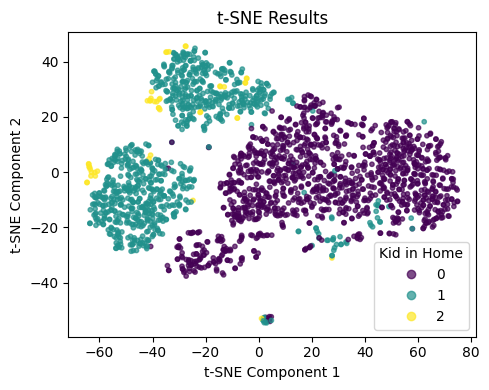

In [ ]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, s=10, c=df['Kidhome'], cmap='viridis')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = df['Kidhome'].unique()
plt.legend(handles, legend_labels, title="Kid in Home")

plt.title('t-SNE Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

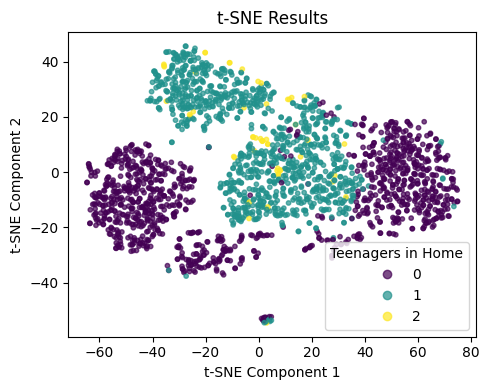

In [ ]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, s=10, c=df['Teenhome'], cmap='viridis')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = df['Teenhome'].unique()
plt.legend(handles, legend_labels, title="Teenagers in Home")

plt.title('t-SNE Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

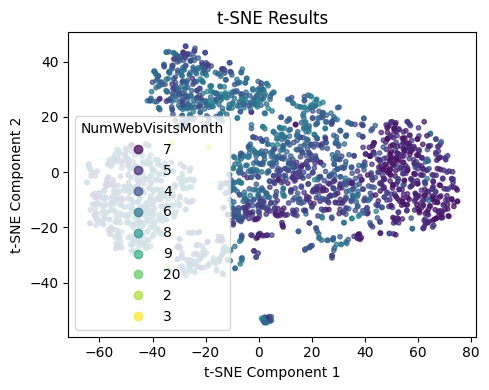

In [ ]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, s=10, c=df['NumWebVisitsMonth'], cmap='viridis')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = df['NumWebVisitsMonth'].unique()
plt.legend(handles, legend_labels, title="NumWebVisitsMonth")

plt.title('t-SNE Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

## Clustering: K-means

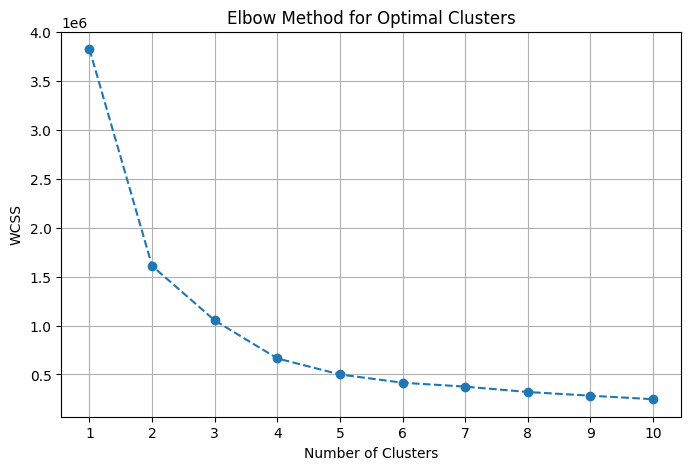

In [ ]:
wcss = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_tsne)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(cluster_range)
plt.grid()
plt.show()

In [ ]:
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans_4.fit(X_tsne)

kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_3.fit(X_tsne)

KMeans(n_clusters=3, n_init='auto', random_state=42)

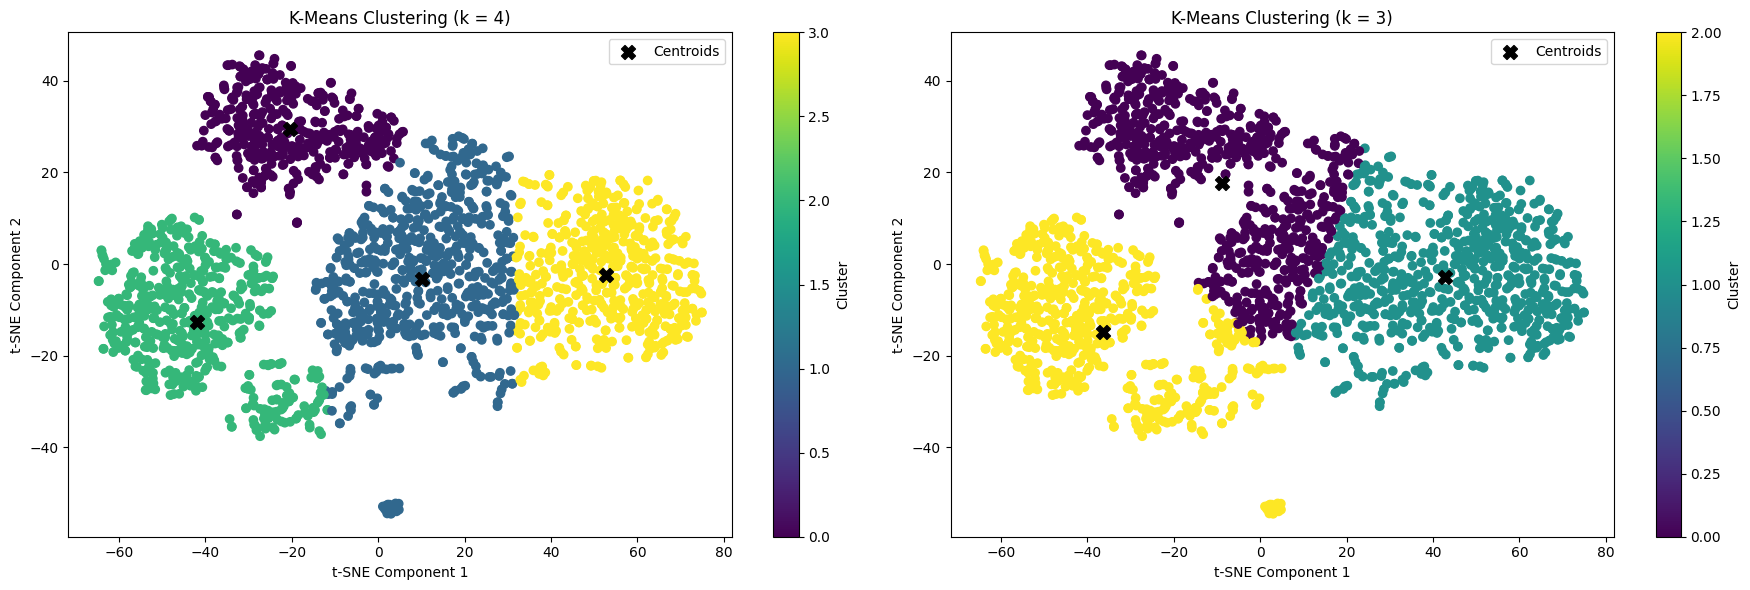

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].set_title("K-Means Clustering (k = 4)")
scatter_4 = axes[0].scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=kmeans_4.labels_,
    cmap='viridis'
)

axes[0].scatter(
    kmeans_4.cluster_centers_[:, 0],
    kmeans_4.cluster_centers_[:, 1],
    s=100,
    c='black',
    marker='X',
    label='Centroids'
)
axes[0].set_xlabel("t-SNE Component 1")
axes[0].set_ylabel("t-SNE Component 2")
axes[0].legend()
fig.colorbar(scatter_4, ax=axes[0], label='Cluster')

axes[1].set_title("K-Means Clustering (k = 3)")
scatter_3 = axes[1].scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=kmeans_3.labels_,
    cmap='viridis'
)

axes[1].scatter(
    kmeans_3.cluster_centers_[:, 0],
    kmeans_3.cluster_centers_[:, 1],
    s=100,
    c='black',
    marker='X',
    label='Centroids'
)
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
axes[1].legend()

fig.colorbar(scatter_3, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

In [ ]:
sil_score_4 = silhouette_score(X_tsne, kmeans_4.labels_)
print(f"Silhouette Score k=4: {sil_score_4}")

sil_score_3 = silhouette_score(X_tsne, kmeans_3.labels_)
print(f"Silhouette Score k=3: {sil_score_3}")

Silhouette Score k=4: 0.47880396246910095
Silhouette Score k=3: 0.44425368309020996


## Clustering: Affinity Propagation

Number of clusters identified: 7
Silhouette Score: 0.45629051327705383


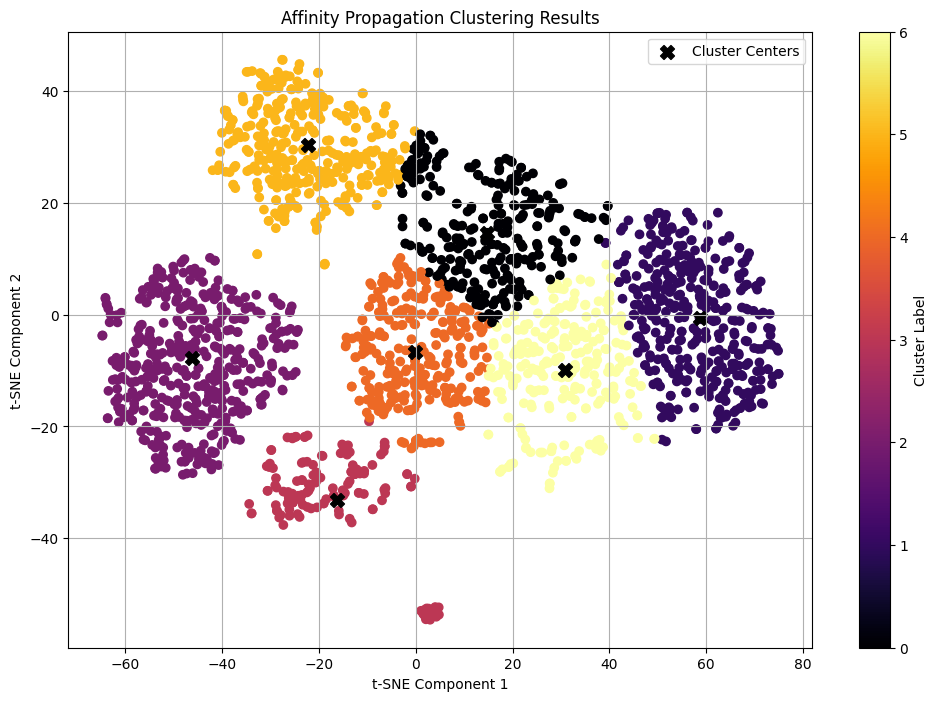

In [ ]:
affinity_propagation = AffinityPropagation(random_state=42, preference=-45000, damping=0.8)
clusters = affinity_propagation.fit_predict(X_tsne)

n_clusters = len(set(clusters))
print(f"Number of clusters identified: {n_clusters}")

sil_score = silhouette_score(X_tsne, clusters)
print(f"Silhouette Score: {sil_score}")

plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=clusters,
    cmap='inferno'
)

cluster_centers = affinity_propagation.cluster_centers_indices_
if cluster_centers is not None:
    plt.scatter(
        X_tsne[cluster_centers, 0],
        X_tsne[cluster_centers, 1],
        s=100,
        c='black',
        marker='X',
        label='Cluster Centers'
    )

plt.colorbar(scatter, label='Cluster Label')
plt.title("Affinity Propagation Clustering Results")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)

plt.show()

## Clustering: GMM

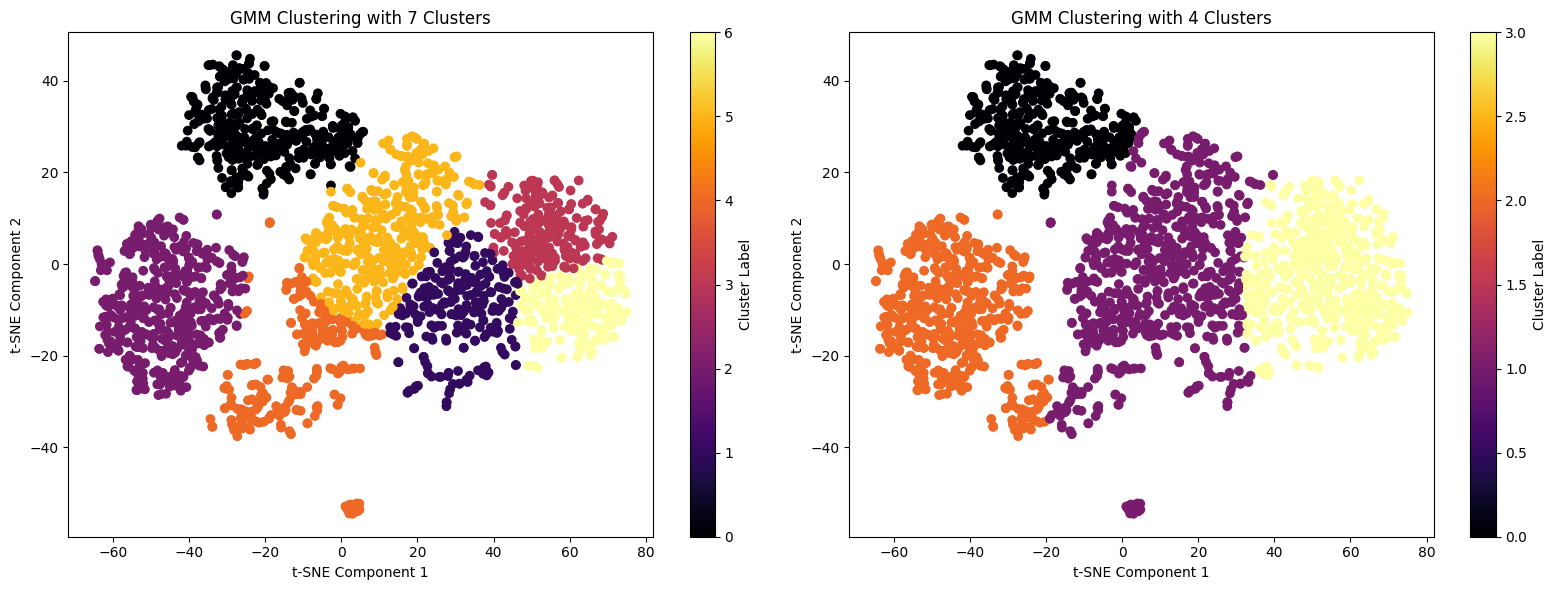

In [ ]:
gmm_7 = GaussianMixture(n_components=7, random_state=42)
gmm_7.fit(X_tsne)
gmm_labels_7 = gmm_7.predict(X_tsne)

gmm_4 = GaussianMixture(n_components=4, random_state=42)
gmm_4.fit(X_tsne)
gmm_labels_4 = gmm_4.predict(X_tsne)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].set_title("GMM Clustering with 7 Clusters")
scatter_7 = axes[0].scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels_7, cmap='inferno'
)
axes[0].set_xlabel("t-SNE Component 1")
axes[0].set_ylabel("t-SNE Component 2")
fig.colorbar(scatter_7, ax=axes[0], label='Cluster Label')

axes[1].set_title("GMM Clustering with 4 Clusters")
scatter_4 = axes[1].scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels_4, cmap='inferno'
)
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
fig.colorbar(scatter_4, ax=axes[1], label='Cluster Label')

plt.tight_layout()
plt.show()

In [ ]:
age_bins = [18, 30, 40, 50, 60, 100]
age_labels = ['18-30', '31-40', '41-50', '51-60', '60+']
df.loc[:, 'Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

income_bins = [0, 30000, 40000, 60000, 80000, 170000]
income_labels = ['0-30k', '31k-40k', '41k-60k', '61k-80k', '80k+']
df.loc[:, 'Income Group'] = pd.cut(df['Income'], bins=income_bins, labels=income_labels, right=False)

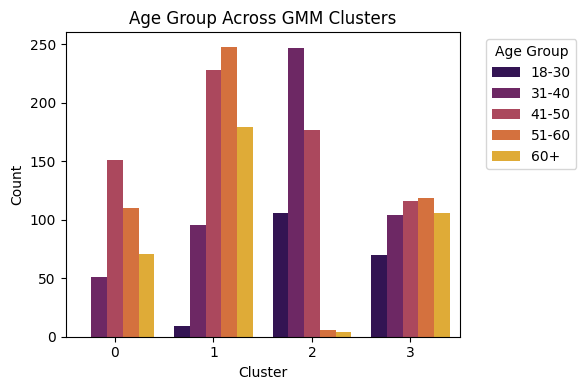

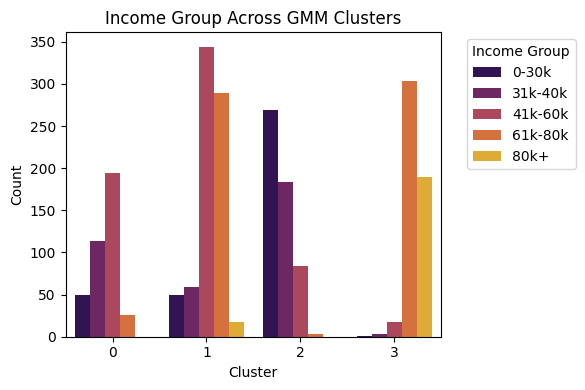

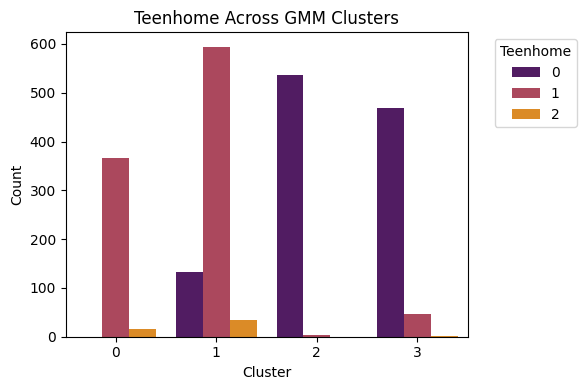

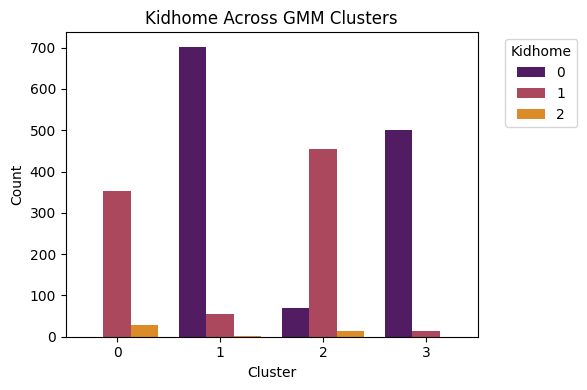

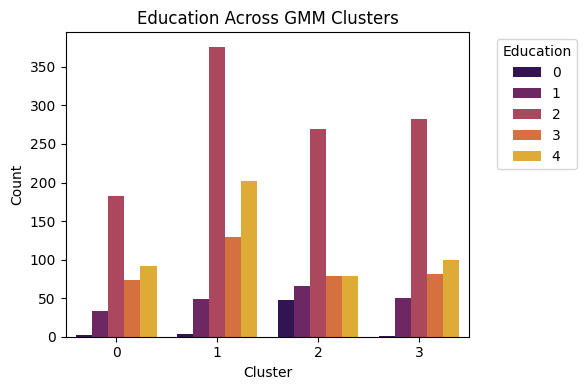

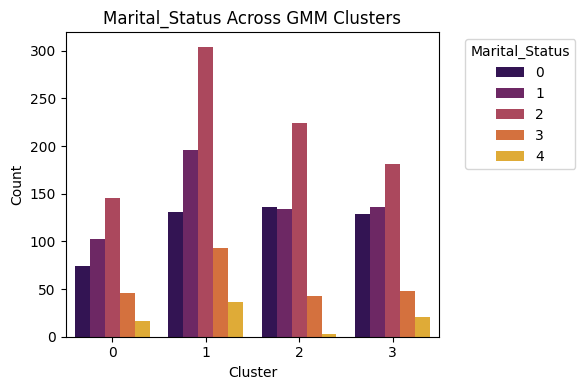

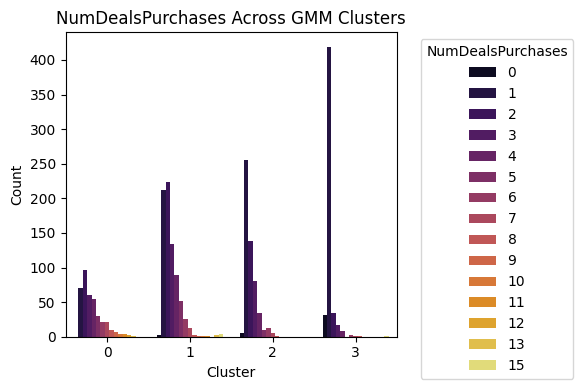

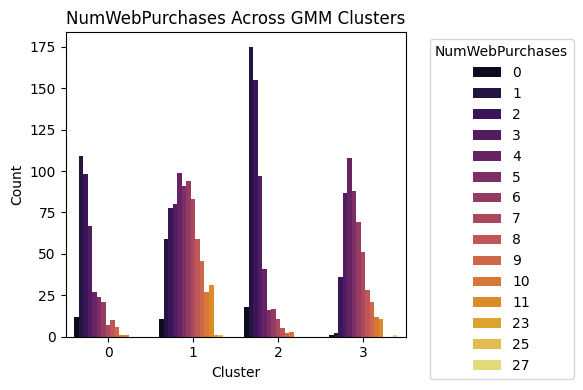

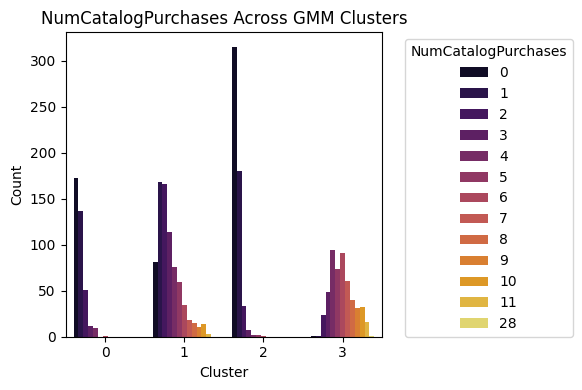

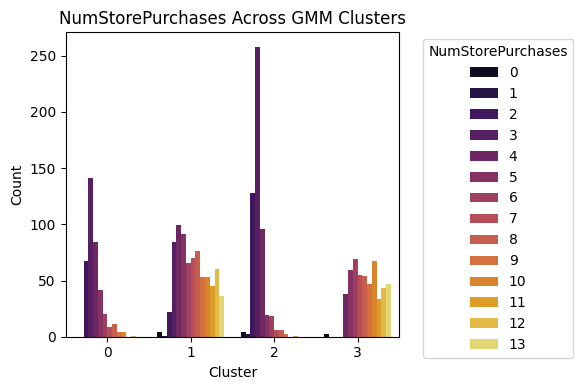

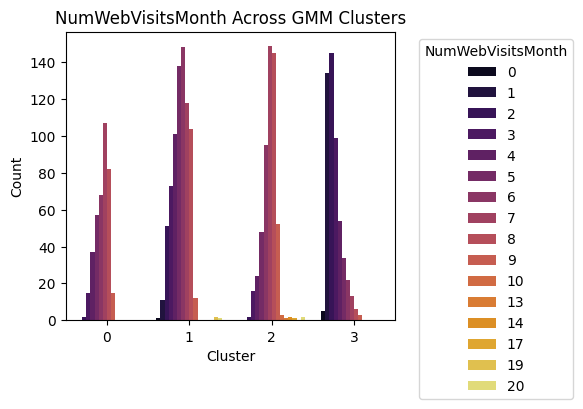

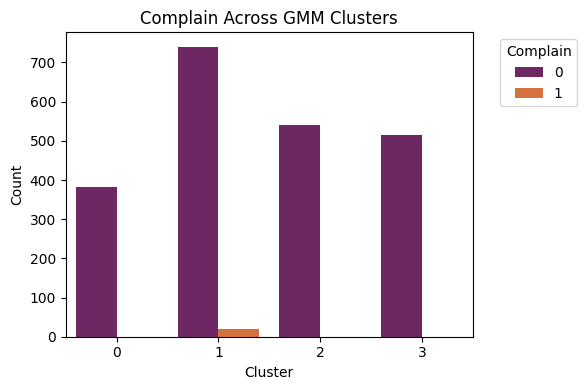

In [ ]:
df.loc[:, 'gmm_4'] = gmm_labels_4

features = ['Age Group', 'Income Group', 'Teenhome', 'Kidhome',
           'Education', 'Marital_Status', 'NumDealsPurchases', 'NumWebPurchases',
            'NumCatalogPurchases', 'NumStorePurchases',	'NumWebVisitsMonth','Complain']

def cluster_vs_feature(features):
    for feature in features:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x='gmm_4', hue=feature, palette='inferno')

        plt.title(f'{feature} Across GMM Clusters')
        plt.xlabel("Cluster")
        plt.ylabel("Count")
        plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

cluster_vs_feature(features)

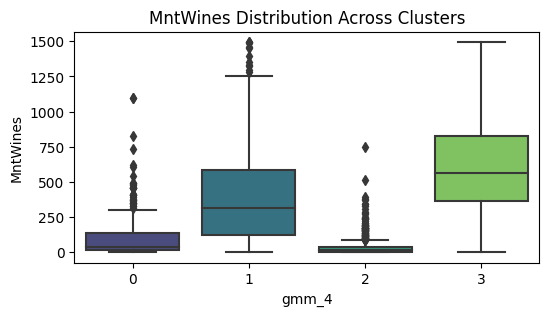

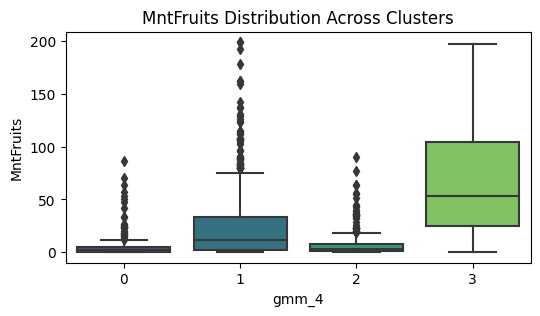

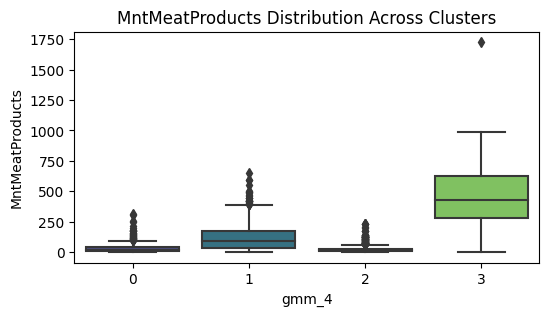

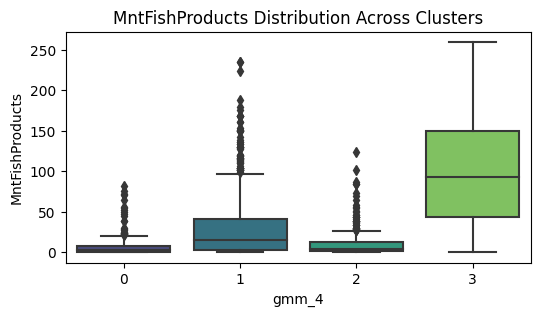

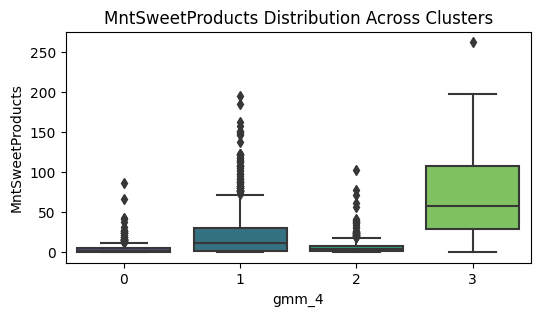

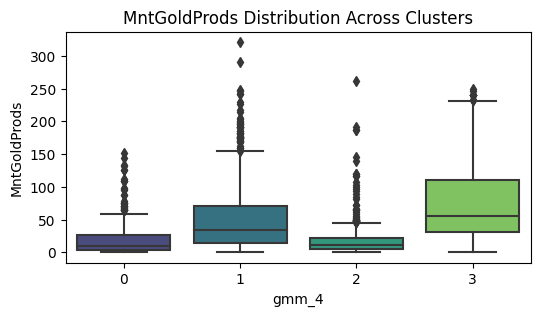

In [ ]:
features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
for feature in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='gmm_4', y=feature, data=df, palette='viridis')
    plt.title(f'{feature} Distribution Across Clusters')
    plt.show()